# PHẦN 0: THIẾT LẬP MÔI TRƯỜNG VÀ CÁC HẰNG SỐ


In [5]:
# --- 0.1. Import các thư viện cần thiết ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Conv1D, GlobalMaxPooling1D, Concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.utils import class_weight

In [6]:
# --- 0.2. Cấu hình và các hằng số ---
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# Đặt SEED để đảm bảo kết quả nhất quán và có thể tái lặp
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Hằng số cho mô hình
N_SPLITS = 5 # Số fold cho Cross-Validation
EPOCHS = 100
BATCH_SIZE = 64
PATIENCE = 10 # Patience cho EarlyStopping

# PHẦN 1: TẢI VÀ TIỀN XỬ LÝ DỮ LIỆU

In [7]:
# --- 1.1. Tải dữ liệu ---

try:
    df_objects = pd.read_csv('/Users/nguyenhoangnam/Downloads/ueh_ml_basic/CAPITAL INVEST/data eda/objects.csv',low_memory= False)
    df_funding_rounds = pd.read_csv('/Users/nguyenhoangnam/Downloads/ueh_ml_basic/CAPITAL INVEST/data eda/funding_rounds.csv')
    df_ipos = pd.read_csv('/Users/nguyenhoangnam/Downloads/ueh_ml_basic/CAPITAL INVEST/data eda/ipos.csv')
    df_acquisitions = pd.read_csv('/Users/nguyenhoangnam/Downloads/ueh_ml_basic/CAPITAL INVEST/data eda/acquisitions.csv')
    df_relationships = pd.read_csv('/Users/nguyenhoangnam/Downloads/ueh_ml_basic/CAPITAL INVEST/data eda/relationships.csv')
    df_milestones = pd.read_csv('/Users/nguyenhoangnam/Downloads/ueh_ml_basic/CAPITAL INVEST/data eda/milestones.csv')
    print("Tải dữ liệu thành công.")
except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy file {e.filename}. Vui lòng kiểm tra lại đường dẫn.")
    # Dừng chương trình nếu không có dữ liệu
    exit()

Tải dữ liệu thành công.


In [8]:
# --- 1.2. Xác định biến mục tiêu và làm sạch cơ bản ---

df_companies = df_objects[df_objects['entity_type'] == 'Company'].copy()

# Xác định công ty thành công (IPO hoặc được mua lại)
ipo_ids = set(df_ipos['object_id'])
acquired_ids = set(df_acquisitions['acquired_object_id'])
successful_ids = ipo_ids.union(acquired_ids)
df_companies['is_successful'] = df_companies['id'].isin(successful_ids).astype(int)

# Chuyển đổi cột ngày tháng
df_companies['founded_at'] = pd.to_datetime(df_companies['founded_at'], errors='coerce')
df_funding_rounds['funded_at'] = pd.to_datetime(df_funding_rounds['funded_at'], errors='coerce')

print("\nPhân phối biến mục tiêu:")
print(df_companies['is_successful'].value_counts(normalize=True))


Phân phối biến mục tiêu:
is_successful
0    0.946437
1    0.053563
Name: proportion, dtype: float64


In [ ]:
# --- 1.3. Feature Engineering ---

# 1.3.1. Tổng hợp thông tin từ các bảng phụ

funding_agg = df_funding_rounds.groupby('object_id').agg(
    total_funding_usd=('raised_amount_usd', 'sum'),
    num_funding_rounds=('id', 'count'),
    first_funding_at=('funded_at', 'min'),
    last_funding_at=('funded_at', 'max'),
    last_round_amount_usd=('raised_amount_usd', 'last')
).reset_index()

milestone_agg = df_milestones.groupby('object_id').agg(num_milestones=('id', 'count')).reset_index()

df_founders = df_relationships[df_relationships['title'].str.contains('founder', case=False, na=False)].copy()
founder_counts = df_founders.groupby('relationship_object_id').size().reset_index(name='num_founders')
team_size = df_relationships.groupby('relationship_object_id').size().reset_index(name='team_size')

cols_to_drop_before_merge = [
    'first_funding_at', 'last_funding_at', 'funding_rounds', 'funding_total_usd',
    'first_milestone_at', 'last_milestone_at', 'milestones', 'relationships'
]
df_companies.drop(columns=cols_to_drop_before_merge, inplace=True, errors='ignore')


# 1.3.2 Gộp các thông tin đã tổng hợp vào bảng chính

df_final = df_companies.copy()
df_final = pd.merge(df_final, funding_agg, left_on='id', right_on='object_id', how='left')
df_final = pd.merge(df_final, milestone_agg, left_on='id', right_on='object_id', how='left')
df_final = pd.merge(df_final, founder_counts, left_on='id', right_on='relationship_object_id', how='left')
df_final = pd.merge(df_final, team_size, left_on='id', right_on='relationship_object_id', how='left')

cols_to_drop_after_merge = [col for col in df_final.columns if 'object_id' in str(col) or 'relationship_object_id' in str(col)]
df_final.drop(columns=cols_to_drop_after_merge, inplace=True)

# 1.3.3. Tạo các đặc trưng về thời gian và tỷ lệ
snapshot_end_date = pd.to_datetime('2013-12-31')
df_final['company_age_years'] = (snapshot_end_date - df_final['founded_at']).dt.days / 365.25
df_final['time_since_last_funding'] = (snapshot_end_date - df_final['last_funding_at']).dt.days / 365.25
df_final['time_to_first_funding'] = (df_final['first_funding_at'] - df_final['founded_at']).dt.days / 365.25
df_final['funding_velocity'] = df_final['total_funding_usd'] / (df_final['company_age_years'] + 1e-6)
df_final['avg_funding_per_round'] = df_final['total_funding_usd'] / (df_final['num_funding_rounds'] + 1e-6)

In [ ]:
df_eda = df_final.copy()

# ---- 1.5. EDA ----

# 1.5.1. Phân tích biến mục tiêu 'is_successful'

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_successful', data=df_eda,palette='viridis')
plt.title('Phân phối của biến mục tiêu (Startup Thành công vs. Thất bại)', fontsize=16)
plt.xlabel('Trạng thái thành công (1: Thành công, 0: Thất bại)')
plt.ylabel('Số lượng công ty')
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

# 1.5.2. Phân tích đặc trưng phân loại 'category_code' (dạng gốc)

plt.figure(figsize=(12, 8))
top_20_cats = df_eda['category_code'].value_counts().nlargest(20)
sns.barplot(y=top_20_cats.index, x=top_20_cats.values, orient='h',palette = 'viridis')
plt.title('Top 20 Ngành/Lĩnh vực có nhiều công ty nhất', fontsize=16)
plt.xlabel('Số lượng công ty')
plt.ylabel('Ngành/Lĩnh vực')
plt.show()

# 1.5.3. Mối quan hệ giữa các đặc trưng và biến mục tiêu

df_eda['log_total_funding'] = np.log1p(df_eda['total_funding_usd'])
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('So sánh đặc trưng giữa nhóm Thành công và Thất bại', fontsize=20)
sns.boxplot(x='is_successful', y='log_total_funding', data=df_eda, ax=axes[0], palette='viridis')
axes[0].set_title('Log(Tổng vốn gọi được)')
axes[0].set_xticklabels(['Thất bại', 'Thành công'])
sns.boxplot(x='is_successful', y='num_milestones', data=df_eda, ax=axes[1], palette = 'viridis')
axes[1].set_title('Số lượng cột mốc')
axes[1].set_xticklabels(['Thất bại', 'Thành công'])
plt.show()

In [ ]:
# 1.5.4. Các ngành/lĩnh vực có tỷ lệ thành công cao nhất

category_success_rate = df_eda.groupby('category_code')['is_successful'].mean().sort_values(ascending=False).nlargest(20)

plt.figure(figsize=(12, 8))
sns.barplot(y=category_success_rate.index, x=category_success_rate.values, orient='h', palette='viridis')
plt.title('Top 20 Ngành/Lĩnh vực có Tỷ lệ thành công cao nhất', fontsize=16)
plt.xlabel('Tỷ lệ thành công')
plt.ylabel('Ngành/Lĩnh vực')
plt.axvline(x=df_eda['is_successful'].mean(), color='r', linestyle='--', label=f'Tỷ lệ trung bình ({df_eda["is_successful"].mean():.2%})')
plt.legend()
plt.show()

In [ ]:
# --- 1.6 Chọn các cột cuối cùng và xử lý giá trị thiếu ---

final_features = [
    'is_successful', 'category_code', 'company_age_years', 'total_funding_usd',
    'num_funding_rounds', 'last_round_amount_usd', 'time_since_last_funding',
    'time_to_first_funding', 'funding_velocity', 'avg_funding_per_round',
    'num_milestones', 'num_founders', 'team_size'
]
df_model_ready = df_final[final_features].copy()
# .dropna(subset=['founded_at']) # Bỏ các công ty không có ngày thành lập

# Điền giá trị thiếu
cols_to_fill_zero = [
    'total_funding_usd', 'num_funding_rounds', 'last_round_amount_usd',
    'num_milestones', 'num_founders', 'team_size', 'funding_velocity', 'avg_funding_per_round'
]
for col in cols_to_fill_zero:
    df_model_ready[col].fillna(0, inplace=True)

cols_to_fill_large = ['time_since_last_funding', 'time_to_first_funding', 'company_age_years']
for col in cols_to_fill_large:
    # Điền giá trị lớn cho các công ty chưa từng gọi vốn hoặc tuổi không xác định
    df_model_ready[col].fillna(df_model_ready[col].max() + 5, inplace=True)

df_model_ready['category_code'].fillna('missing', inplace=True)


In [ ]:
# --- 1.7. Xử lý cột phân loại 'category_code' ----

top_categories = df_model_ready['category_code'].value_counts().nlargest(20).index
df_model_ready['category_code'] = df_model_ready['category_code'].where(df_model_ready['category_code'].isin(top_categories), 'other')
df_model_ready = pd.get_dummies(df_model_ready, columns=['category_code'], drop_first=True)

print("Hoàn thành Feature Engineering.")
print(f"Kích thước DataFrame cuối cùng cho mô hình: {df_model_ready.shape}")

In [ ]:
# ---- 1.8. Ma trận tương quan trên dữ liệu cuối cùng (`df_model_ready`) ----

plt.figure(figsize=(14, 10))
# Chọn các cột số chính để tránh heatmap quá lớn
corr_cols_model = ['is_successful', 'company_age_years', 'total_funding_usd', 'num_funding_rounds', 'num_milestones', 'num_founders', 'team_size']
correlation_matrix = df_model_ready[[col for col in corr_cols_model if col in df_model_ready.columns]].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Ma trận tương quan giữa các đặc trưng chính (dữ liệu model)', fontsize=16)
plt.show()

print("Hoàn thành EDA. Dữ liệu đã sẵn sàng cho mô hình.")


# PHẦN 2: CHUẨN BỊ DỮ LIỆU VÀ THIẾT LẬP CROSS-VALIDATION


In [10]:
# --- 2.1. Tách X và y ---
X = df_model_ready.drop(columns=['is_successful'])
y = df_model_ready['is_successful']

In [11]:
# --- 2.2. Thiết lập Stratified K-Fold ---
# Sử dụng Stratified K-Fold để đảm bảo tỷ lệ các lớp được giữ nguyên trong mỗi fold,
# rất quan trọng cho dữ liệu mất cân bằng.
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

In [12]:
# --- 2.3. Khởi tạo nơi lưu trữ kết quả ---
# Dùng dictionary để lưu điểm AUC của mỗi mô hình qua các fold
results = {
    'MLP': [],
    'XGBoost': [],
    'CNN': [],
    'LSTM': []
}
# Lưu lại lịch sử training và dự đoán của fold cuối cùng để vẽ đồ thị
histories = {}
last_fold_predictions = {}
last_fold_data = {}

# PHẦN 3: CÁC HÀM HỖ TRỢ ĐỂ XÂY DỰNG MÔ HÌNH


In [13]:
def create_mlp_model(input_dim):
    """Hàm tạo mô hình MLP"""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

def create_cnn_model(input_shape):
    """Hàm tạo mô hình 1D-CNN"""
    model_input = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(model_input) # Thêm padding='same' để xử lý biên
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    model_output = Dense(1, activation='sigmoid')(x)
    model = Model(model_input, model_output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

def create_lstm_model(input_shape):
    """Hàm tạo mô hình LSTM"""
    model_input = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3))(model_input)
    x = Dense(32, activation='relu')(x)
    model_output = Dense(1, activation='sigmoid')(x)
    model = Model(model_input, model_output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

def create_simulated_sequences(data_2d, n_timesteps=12):
    """
    Tạo chuỗi thời gian giả lập từ dữ liệu 2D.
    Mỗi mẫu sẽ được biến thành một chuỗi (n_timesteps, n_features).
    """
    n_samples, n_features = data_2d.shape
    data_3d = np.zeros((n_samples, n_timesteps, n_features))
    
    for i in range(n_samples):
        for t in range(n_timesteps):
            progression_factor = (t + 1) / n_timesteps
            noise = np.random.normal(0, 0.1, n_features)
            data_3d[i, t, :] = data_2d[i, :] * progression_factor + noise
            
    return data_3d

print("Các hàm xây dựng mô hình đã sẵn sàng.")

Các hàm xây dựng mô hình đã sẵn sàng.


# PHẦN 4: HUẤN LUYỆN VÀ ĐÁNH GIÁ CÁC MÔ HÌNH BẰNG K-FOLD


In [14]:
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"\n========== FOLD {fold + 1}/{N_SPLITS} ==========")

    # --- 4.1. Chia dữ liệu và chuẩn hóa ---
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    class_weights_dict = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
    early_stopping = EarlyStopping(monitor='val_auc', patience=PATIENCE, mode='max', restore_best_weights=True, verbose=0)

    # --- 4.2. Huấn luyện và đánh giá từng mô hình với TRY-EXCEPT ---

    # --- a. Mô hình MLP ---
    try:
        print("--- Training MLP ---")
        model_mlp = create_mlp_model(X_train_scaled.shape[1])
        history_mlp = model_mlp.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights_dict, callbacks=[early_stopping], verbose=0)
        y_pred_mlp = model_mlp.predict(X_val_scaled).flatten()
        auc_mlp = roc_auc_score(y_val, y_pred_mlp)
        results['MLP'].append(auc_mlp)
        print(f"MLP AUC: {auc_mlp:.4f}")
        if fold == N_SPLITS - 1:
            histories['MLP'] = history_mlp
            last_fold_predictions['MLP'] = y_pred_mlp
    except Exception as e:
        print(f"!!!!!! LỖI KHI HUẤN LUYỆN MLP ở Fold {fold + 1}: {e} !!!!!!")

    # --- b. Mô hình XGBoost ---
    try:
        print("--- Training XGBoost ---")
        dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
        dval = xgb.DMatrix(X_val_scaled, label=y_val)
        scale_pos_weight = class_weights_dict[1] / class_weights_dict[0]
        params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': scale_pos_weight, 'seed': SEED}
        model_xgb = xgb.train(params, dtrain, num_boost_round=500, evals=[(dval, 'eval')], early_stopping_rounds=PATIENCE+10, verbose_eval=False)
        y_pred_xgb = model_xgb.predict(dval)
        auc_xgb = roc_auc_score(y_val, y_pred_xgb)
        results['XGBoost'].append(auc_xgb)
        print(f"XGBoost AUC: {auc_xgb:.4f}")
        if fold == N_SPLITS - 1:
            last_fold_predictions['XGBoost'] = y_pred_xgb
    except Exception as e:
        print(f"!!!!!! LỖI KHI HUẤN LUYỆN XGBoost ở Fold {fold + 1}: {e} !!!!!!")

    # --- c/d. Chuẩn bị dữ liệu chuỗi thời gian giả lập ---
    print("--- Preparing simulated sequence data for CNN/LSTM ---")
    X_train_3d = create_simulated_sequences(X_train_scaled, n_timesteps=12)
    X_val_3d = create_simulated_sequences(X_val_scaled, n_timesteps=12)

    # --- c. Mô hình CNN ---
    try:
        print("--- Training CNN ---")
        model_cnn = create_cnn_model((X_train_3d.shape[1], X_train_3d.shape[2]))
        history_cnn = model_cnn.fit(X_train_3d, y_train, validation_data=(X_val_3d, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights_dict, callbacks=[early_stopping], verbose=0)
        y_pred_cnn = model_cnn.predict(X_val_3d).flatten()
        auc_cnn = roc_auc_score(y_val, y_pred_cnn)
        results['CNN'].append(auc_cnn)
        print(f"CNN AUC: {auc_cnn:.4f}")
        if fold == N_SPLITS - 1:
            histories['CNN'] = history_cnn
            last_fold_predictions['CNN'] = y_pred_cnn
    except Exception as e:
        print(f"!!!!!! LỖI KHI HUẤN LUYỆN CNN ở Fold {fold + 1}: {e} !!!!!!")

    # --- d. Mô hình LSTM ---
    try:
        print("--- Training LSTM ---")
        model_lstm = create_lstm_model((X_train_3d.shape[1], X_train_3d.shape[2]))
        history_lstm = model_lstm.fit(X_train_3d, y_train, validation_data=(X_val_3d, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights_dict, callbacks=[early_stopping], verbose=0)
        y_pred_lstm = model_lstm.predict(X_val_3d).flatten()
        auc_lstm = roc_auc_score(y_val, y_pred_lstm)
        results['LSTM'].append(auc_lstm)
        print(f"LSTM AUC: {auc_lstm:.4f}")
        if fold == N_SPLITS - 1:
            histories['LSTM'] = history_lstm
            last_fold_predictions['LSTM'] = y_pred_lstm
    except Exception as e:
        print(f"!!!!!! LỖI KHI HUẤN LUYỆN LSTM ở Fold {fold + 1}: {e} !!!!!!")

    # Lưu y_val của fold cuối
    if fold == N_SPLITS - 1:
        last_fold_data['y_val'] = y_val


========== FOLD 1/5 ==========
--- Training MLP ---
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
MLP AUC: 0.8388
--- Training XGBoost ---
XGBoost AUC: 0.8467
--- Preparing simulated sequence data for CNN/LSTM ---
--- Training CNN ---
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
CNN AUC: 0.8102
--- Training LSTM ---
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
LSTM AUC: 0.7917

========== FOLD 2/5 ==========
--- Training MLP ---
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
MLP AUC: 0.8345
--- Training XGBoost ---
XGBoost AUC: 0.8432
--- Preparing simulated sequence data for CNN/LSTM ---
--- Training CNN ---
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step
CNN AUC: 0.8019
--- Training LSTM ---
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
LSTM AUC: 0.7809

========== FOLD 3/5 ==========
--- Training MLP ---
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
MLP AUC: 0.8414
--- Training XGBoost ---
XGBoost AUC: 0.8493
--- Preparing simulated sequence data for CNN/LSTM ---
--- Training CNN ---
1229/1229

# PHẦN 5: SO SÁNH TỔNG QUAN CÁC MÔ HÌNH


In [15]:
# --- 5.1. Bảng tổng kết kết quả Cross-Validation ---
results_df = pd.DataFrame(results)
summary_df = results_df.agg(['mean', 'std']).T
summary_df.columns = ['Mean AUC', 'Std Dev']
print("\nBảng tổng kết kết quả Cross-Validation:")
print(summary_df.sort_values(by='Mean AUC', ascending=False))


Bảng tổng kết kết quả Cross-Validation:
         Mean AUC   Std Dev
XGBoost  0.844830  0.003353
MLP      0.836518  0.004355
CNN      0.804380  0.004965
LSTM     0.780906  0.006802


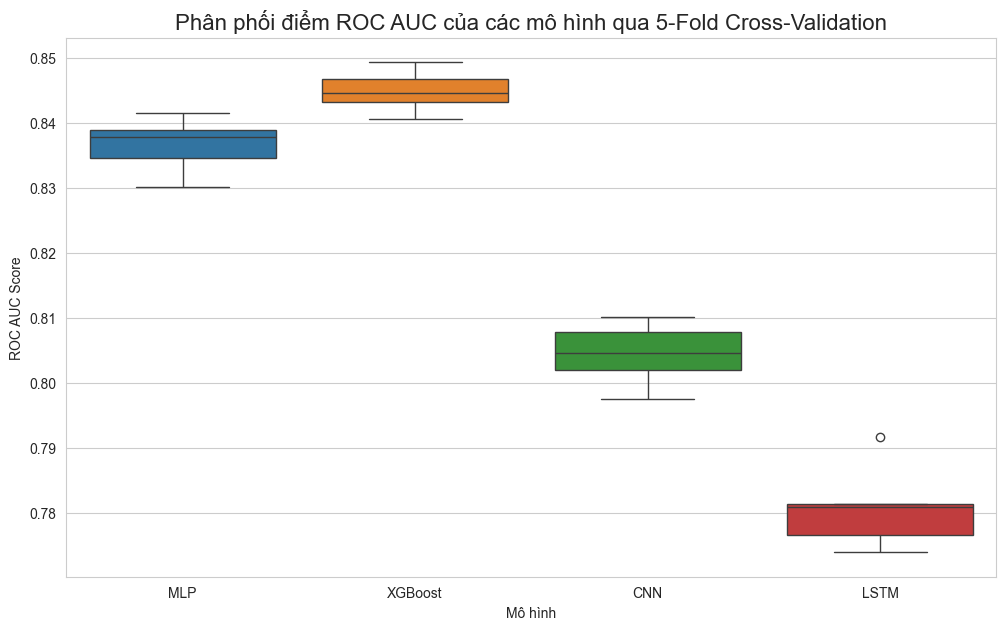

In [16]:
# --- 5.2. Trực quan hóa kết quả Cross-Validation ---
plt.figure(figsize=(12, 7))
sns.boxplot(data=results_df)
plt.title('Phân phối điểm ROC AUC của các mô hình qua 5-Fold Cross-Validation', fontsize=16)
plt.ylabel('ROC AUC Score')
plt.xlabel('Mô hình')
plt.show()

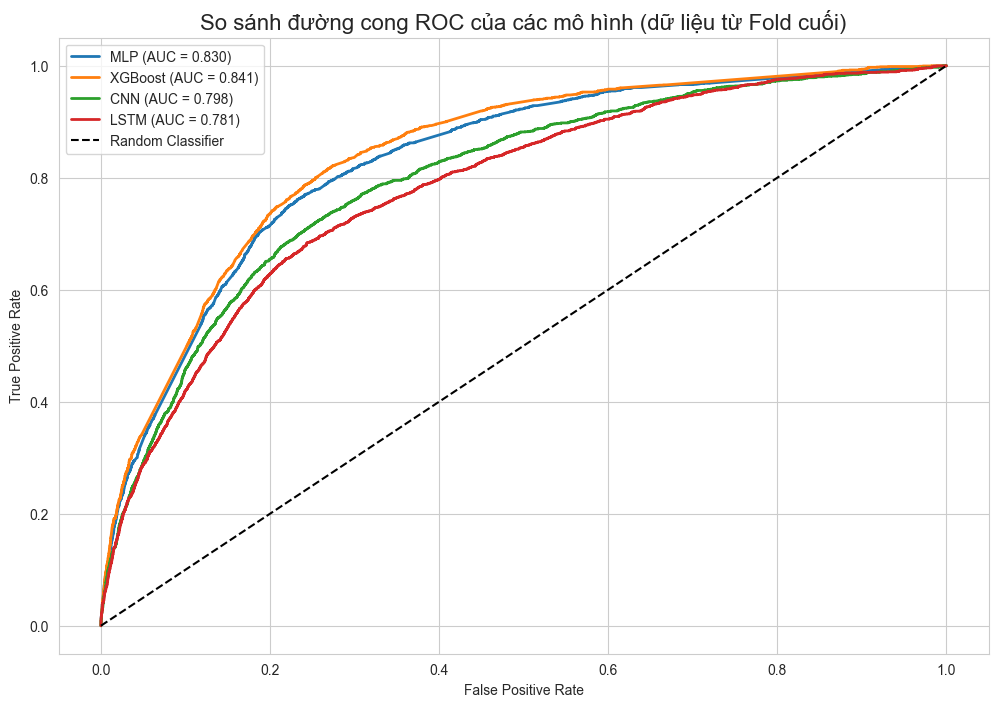

In [17]:
# --- 5.3. Trực quan hóa đường cong ROC của các mô hình (từ fold cuối) ---
plt.figure(figsize=(12, 8))
for model_name, y_pred in last_fold_predictions.items():
    fpr, tpr, _ = roc_curve(last_fold_data['y_val'], y_pred)
    auc_score = roc_auc_score(last_fold_data['y_val'], y_pred)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('So sánh đường cong ROC của các mô hình (dữ liệu từ Fold cuối)', fontsize=16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# PHẦN 6: PHÂN TÍCH SÂU MÔ HÌNH TỐT NHẤT


In [40]:
from sklearn.metrics import precision_recall_curve, f1_score

In [41]:
best_model_name = summary_df['Mean AUC'].idxmax()
print(f"\nPHẦN 6: PHÂN TÍCH SÂU MÔ HÌNH TỐT NHẤT: {best_model_name}")



PHẦN 6: PHÂN TÍCH SÂU MÔ HÌNH TỐT NHẤT: XGBoost


Phân tích mô hình XGBoost từ fold cuối cùng...

--- Tinh chỉnh Ngưỡng Quyết định cho XGBoost ---
Ngưỡng mặc định 0.5 có F1-score: 0.2610
Ngưỡng tối ưu hóa F1-score là: 0.7726 (với F1-score = 0.3145)


(0.0, 1.05)

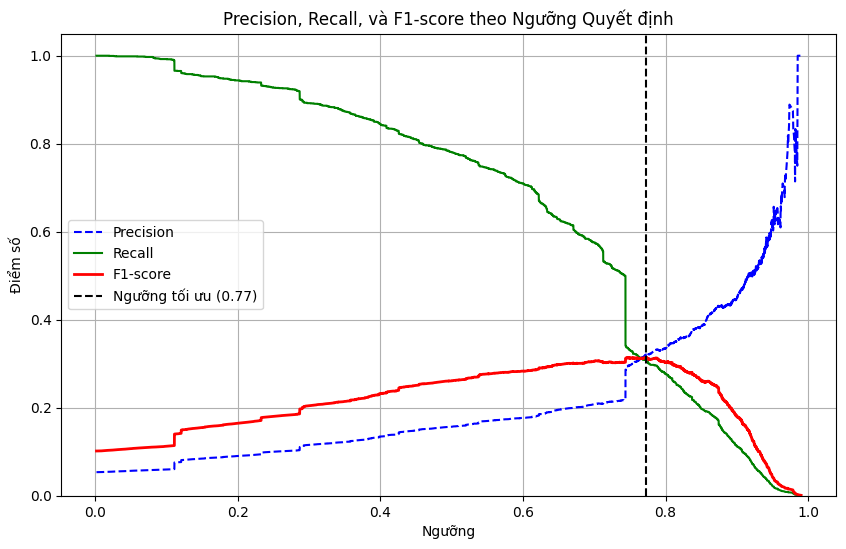

In [44]:
# --- 6.1. Huấn luyện lại mô hình tốt nhất trên toàn bộ dữ liệu ---


print(f"Phân tích mô hình {best_model_name} từ fold cuối cùng...")

y_val_final = last_fold_data['y_val']
y_pred_final = last_fold_predictions[best_model_name]
y_pred_class_final = (y_pred_final > 0.77).astype(int)

# Lấy precision, recall, và thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val_final, y_pred_final)

# Tìm ngưỡng tối ưu hóa F1-score
# Bỏ đi giá trị cuối cùng của thresholds để khớp với độ dài của precision/recall
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_f1_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]

print(f"\n--- Tinh chỉnh Ngưỡng Quyết định cho XGBoost ---")
print(f"Ngưỡng mặc định 0.5 có F1-score: {f1_score(y_val_final, (y_pred_final > 0.5).astype(int)):.4f}")
print(f"Ngưỡng tối ưu hóa F1-score là: {best_threshold:.4f} (với F1-score = {best_f1:.4f})")

# Vẽ đồ thị Precision-Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "r-", label="F1-score", lw=2)
plt.axvline(x=best_threshold, color='k', linestyle='--', label=f'Ngưỡng tối ưu ({best_threshold:.2f})')
plt.title('Precision, Recall, và F1-score theo Ngưỡng Quyết định')
plt.xlabel('Ngưỡng')
plt.ylabel('Điểm số')
plt.legend()
plt.grid(True)
plt.ylim([0, 1.05])


Classification Report cho XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     37205
           1       0.32      0.31      0.31      2105

    accuracy                           0.93     39310
   macro avg       0.64      0.64      0.64     39310
weighted avg       0.93      0.93      0.93     39310



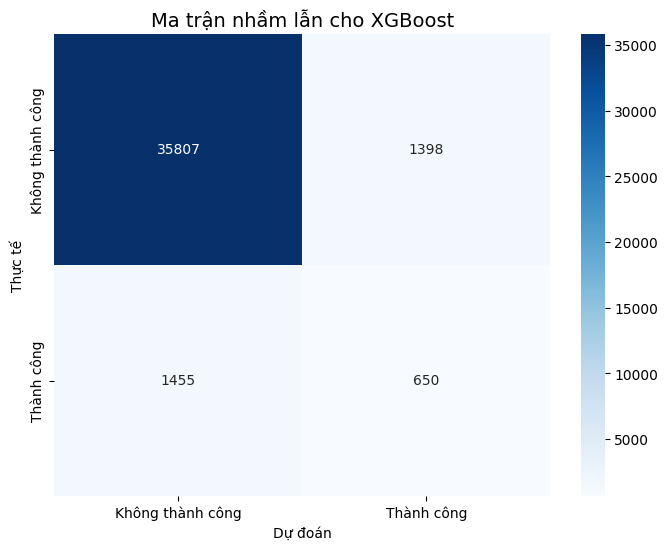

In [46]:
# --- 6.2. Báo cáo chi tiết và Ma trận nhầm lẫn ---

print(f"\nClassification Report cho {best_model_name}:")
print(classification_report(y_val_final, y_pred_class_final))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val_final, y_pred_class_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Không thành công', 'Thành công'],
            yticklabels=['Không thành công', 'Thành công'])
plt.title(f'Ma trận nhầm lẫn cho {best_model_name}', fontsize=14)
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

In [51]:
# --- 6.3. Phân tích Learning Curves (nếu là mô hình Deep Learning) ---

if best_model_name in histories:
    history = histories[best_model_name]
    plt.figure(figsize=(14, 5))

    # Đồ thị AUC
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title(f'Learning Curve - AUC của {best_model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    # Đồ thị Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curve - Loss của {best_model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

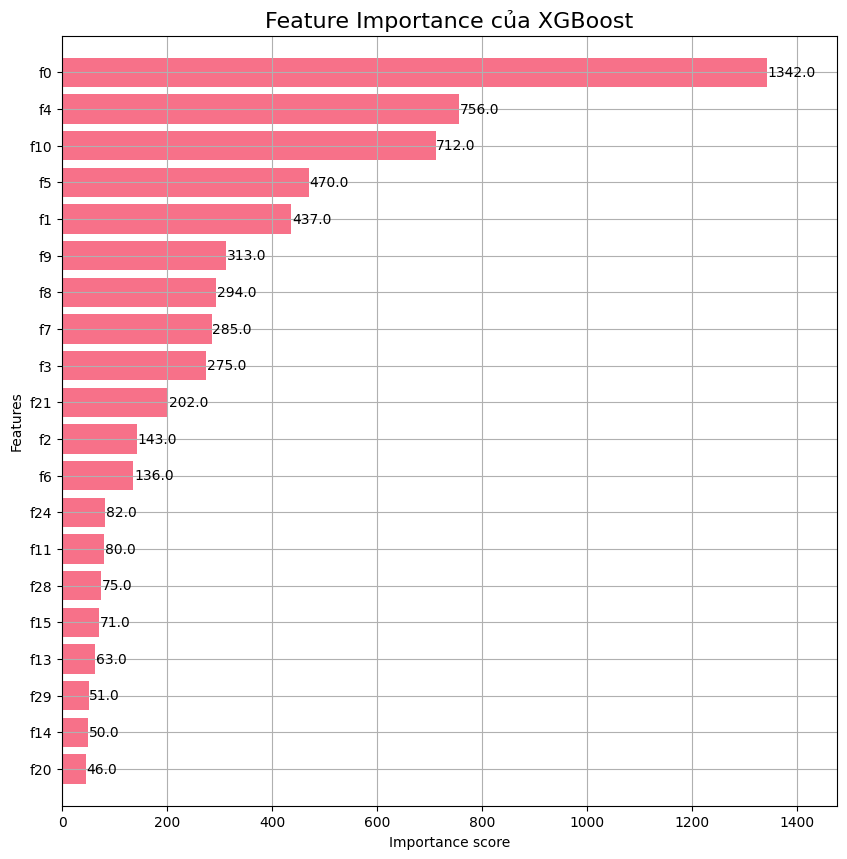

In [48]:
# --- 6.4. Phân tích Feature Importance (nếu là XGBoost) ---
if best_model_name == 'XGBoost':
    plt.figure(figsize=(10, 10))
    xgb.plot_importance(model_xgb, max_num_features=20, height=0.8, ax=plt.gca())
    plt.title('Feature Importance của XGBoost', fontsize=16)
    plt.show()

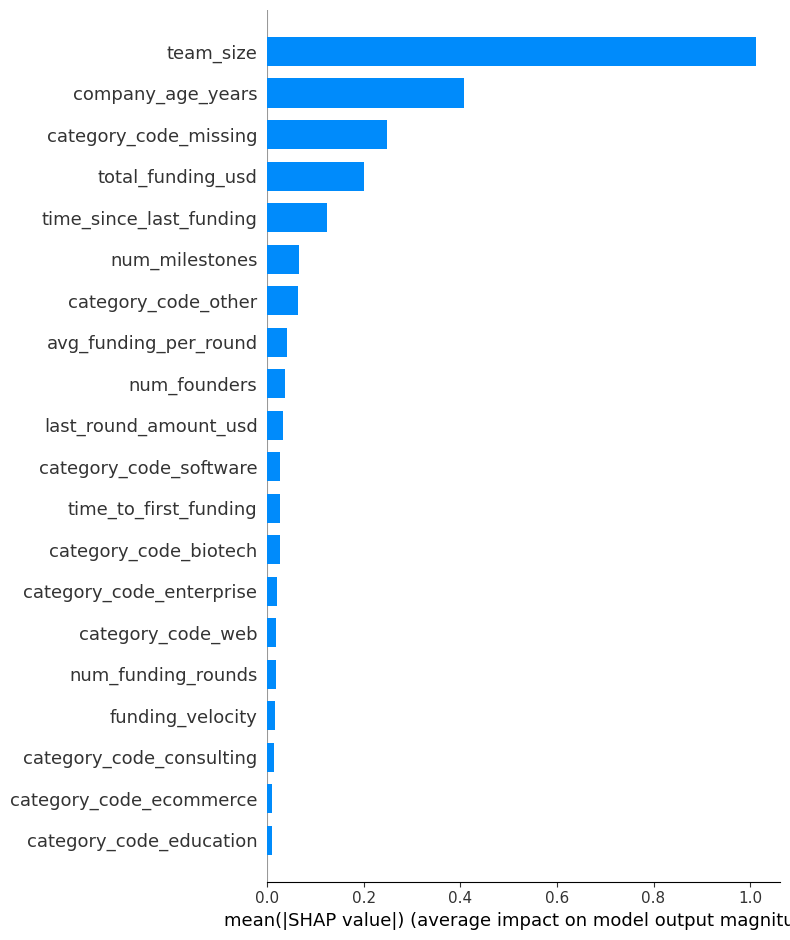

In [52]:
# === PHẦN 6b: Huấn luyện lại best_model trên toàn bộ dữ liệu & Explainability với SHAP ===

import shap
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# 1. Chuẩn hóa toàn bộ X
scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)

# 2. Tạo/compile lại best_model trên full data
if best_model_name == 'MLP':
    best_model = create_mlp_model(input_dim=X_scaled.shape[1])
    model_input = X_scaled

elif best_model_name in ['LSTM', 'CNN', 'LSTM-CNN']:
    # reshape 3D cho sequence models
    X_3d = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
    if best_model_name == 'LSTM':
        best_model = create_lstm_model(input_shape=(X_scaled.shape[1], 1))
    elif best_model_name == 'CNN':
        best_model = create_cnn_model(input_shape=(X_scaled.shape[1], 1))
    else:  # 'LSTM-CNN'
        best_model = create_lstm_cnn_model(input_shape=(X_scaled.shape[1], 1))
    model_input = X_3d

elif best_model_name == 'XGBoost':
    # Với XGBoost, bạn đã có model_xgb trained trong code trước
    best_model = model_xgb
    model_input = X  # shap sẽ tự chuyển DataFrame

# Compile & fit (chỉ với keras models)
if best_model_name != 'XGBoost':
    best_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['AUC'])
    best_model.fit(
        model_input, y,
        epochs=50,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[
            EarlyStopping(monitor='val_auc', patience=PATIENCE,
                          mode='max', restore_best_weights=True)
        ],
        verbose=0
    )

# 3. Chuẩn bị background/sample cho SHAP
# Chọn ngẫu nhiên 100 điểm làm background (baseline)
if best_model_name == 'XGBoost':
    explainer = shap.TreeExplainer(best_model)
    X_sample = X.sample(n=200, random_state=42)
    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample, plot_type='bar')
else:
    # Keras DeepExplainer
    background = model_input[np.random.choice(model_input.shape[0], 100, replace=False)]
    explainer = shap.DeepExplainer(best_model, background)
    # Lấy 200 sample để giải thích
    X_sample = model_input[np.random.choice(model_input.shape[0], 200, replace=False)]
    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample, plot_type='bar')
